In [163]:
import pandas as pd
import numpy as np
import pandas_datareader.data as web
import datetime
import yfinance as yf
from yahoofinancials import YahooFinancials
import time
import requests
import io
import matplotlib.pyplot as plt
import scipy.stats as stats
from statsmodels.stats.diagnostic import acorr_ljungbox
from sklearn import linear_model
import seaborn as sns
import statsmodels.api as sm
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import metrics
import scipy as sp
import scipy.stats as sps
from scipy.stats import norm
from sklearn.metrics import r2_score

# Exercise 1 - Asset Price Properties

### Importing S&P Data from Yahoo Finance

In [27]:
pd.core.common.is_list_like = pd.api.types.is_list_like

start = datetime.datetime(1990,1,1)
end = datetime.datetime(2019,3,31)

SP500 = web.DataReader('^GSPC', 'yahoo', start, end)

In [104]:
SP500.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
1990-01-02,359.690002,351.980011,353.399994,359.690002,162070000,359.690002
1990-01-03,360.589996,357.890015,359.690002,358.760010,192330000,358.760010
1990-01-04,358.760010,352.890015,358.760010,355.670013,177000000,355.670013
1990-01-05,355.670013,351.350006,355.670013,352.200012,158530000,352.200012
1990-01-08,354.239990,350.540009,352.200012,353.790009,140110000,353.790009


In [28]:
SP500['Log Return'] = np.log(SP500['Adj Close']) - np.log(SP500['Adj Close'].shift(1))
SP500['Log Return'] = SP500['Log Return'].fillna(0)
SP500.reset_index(inplace=True)

#### Tested the serial correlation of returns using the Ljung-Box test

In [106]:
#Ljung-Box test-statistic with 10 lags
acorr_ljungbox(SP500['Log Return'], lags=[10])

/opt/anaconda3/lib/python3.8/site-packages/statsmodels/stats/diagnostic.py:524: FutureWarning: The value returned will change to a single DataFrame after 0.12 is released.  Set return_df to True to use to return a DataFrame now.  Set return_df to False to silence this warning.
  warnings.warn(msg, FutureWarning)


(array([60.4229128]), array([3.01411927e-09]))

#### Tested that log returns are normally distributed using the Jarque-Bera test

In [107]:
#Jarque-Bera test statistic
stats.jarque_bera(SP500['Log Return'])

Jarque_beraResult(statistic=23914.45561822885, pvalue=0.0)

In [108]:
SP500['Log Return'].skew()

-0.25888134015900843

In [109]:
SP500['Log Return'].kurt()

8.817544772429105

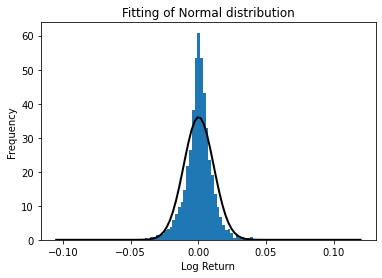

In [97]:
#We fitted a Normal distribution to visually check our data distribution
mu, std = norm.fit(SP500['Log Return']) 

plt.hist(SP500['Log Return'], bins=100, density=True)

xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
 
plt.plot(x, p, 'k', linewidth=2)

plt.ylabel('Frequency')
plt.xlabel('Log Return') 
plt.title("Fitting of Normal distribution")
plt.show()

#### Yang & Zhang Estimator of Volatility

In [30]:
SP500['N_Open']  = np.log(SP500['Open']) - np.log(SP500['Close'].shift(1))
SP500['N_Open'] = SP500['N_Open'].fillna(0)
SP500['N_High'] = np.log(SP500['High']) - np.log(SP500['Open'])
SP500['N_Low'] = np.log(SP500['Low']) - np.log(SP500['Open'])
SP500['N_Close'] = np.log(SP500['Close']) - np.log(SP500['Open'])

In [31]:
YZ_volatility = []

for i in SP500['Year-Month'].unique():
    
    df = SP500[SP500['Year-Month'] == i]

    T = len(df)
    k = 0.34/(1.34 + (T+1)/(T-1))
    sigma_rs = np.mean((df['N_High']*(df['N_High'] - df['N_Close']) + 
                    df['N_Low']*(df['N_Low'] - df['N_Close'])))

    YZ_sigma = np.var(df['N_Open']) + k*np.var(df['N_Close']) + (1-k)*sigma_rs
    
    YZ_volatility.append(YZ_sigma)

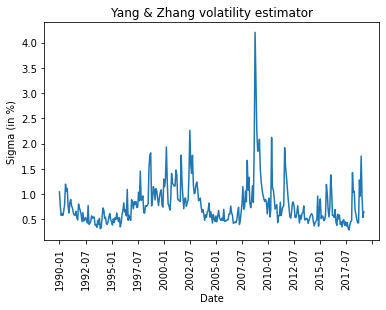

In [34]:
fig, ax = plt.subplots()

x = SP500['Year-Month'].unique()
y = (np.array(YZ_volatility)**0.5)*100

plt.plot(x,y)
plt.xlabel('Date')
plt.xticks(rotation = 90)

plt.ylabel('Sigma (in %)')
plt.title('Yang & Zhang volatility estimator')

ax.xaxis.set_major_locator(plt.MaxNLocator(15))

plt.show()

# Exercise 2 - BS Implied Rate

In [103]:
def BScallPrice(sigma,K,tau,S,r):
    d1 = (np.log(S/K)+(r+(1/2)*sigma**2)*tau)/(sigma*np.sqrt(tau));
    d2 = d1-sigma*np.sqrt(tau);
    c = S*sps.norm.cdf(d1)-K*np.exp(-r*tau)*sps.norm.cdf(d2);
    return (c)
 
def BSputPrice(sigma,K,tau,S,r):    
    d1 = (np.log(S/K)+(r+(1/2)*sigma**2)*tau)/(sigma*np.sqrt(tau));
    d2 = d1-sigma*np.sqrt(tau);
    c = S*sps.norm.cdf(d1)-K*np.exp(-r*tau)*sps.norm.cdf(d2);
    p = c+K*np.exp(-r*tau)-S;
    return p

In [104]:
def BScallRate (CallPrice, sigma, K, tau, S):
    def BS_cvol(r):
        return (np.mean((BScallPrice(sigma,K,tau,S,r)-CallPrice)**2))
    rate = sp.optimize.minimize(BS_cvol,0.1)
    return rate.x

In [105]:
def BSputRate (PutPrice, sigma, K, tau, S):
    def BS_pvol(r):
        return (np.mean((BSputPrice(sigma,K,tau,S,r)-PutPrice)**2))
    rate = sp.optimize.minimize(BS_pvol,0.1)
    return rate.x

# Exercise 3 - Practitioner's Black-Scholes

In [60]:
SPX_Opt = pd.read_csv("SPX_Options_Cleaned_199001_201803.csv",sep=";")
SPX_Opt.head()

,IVol,day,maturity,month,price,stock,strike,type,year
0,0.1345,3,17,1,4.125,358.76,360,1,1990
1,0.2023,3,17,1,1.188,358.76,345,2,1990
2,0.1789,3,17,1,1.813,358.76,350,2,1990
3,0.1645,3,17,1,2.813,358.76,355,2,1990
4,0.1566,3,17,1,4.625,358.76,360,2,1990


### Classified options by moneyness

In [61]:
# create a list of our conditions
conditions = [
    (SPX_Opt['type'] == 1) & (SPX_Opt['stock']/SPX_Opt['strike'] > 1.01), #ITM Call 
    (SPX_Opt['type'] == 1) & (SPX_Opt['stock']/SPX_Opt['strike'] >= 0.99) & (SPX_Opt['stock']-SPX_Opt['strike'] <= 1.01), #ATM Call
    (SPX_Opt['type'] == 1) & (SPX_Opt['stock']/SPX_Opt['strike'] < 0.99), #OTM Call
    (SPX_Opt['type'] == 2) & (SPX_Opt['strike']/SPX_Opt['stock'] > 1.01), #ITM Put
    (SPX_Opt['type'] == 2) & (SPX_Opt['strike']/SPX_Opt['stock'] >= 0.99) & (SPX_Opt['strike']-SPX_Opt['stock'] <= 1.01),#ATM Put
    (SPX_Opt['type'] == 2) & (SPX_Opt['strike']/SPX_Opt['stock'] < 0.99), #OTM Put
    ]

# create a list of the values we want to assign for each condition
values = [1, 0, -1, 1, 0, -1]

# create a new column and use np.select to assign values to it using our lists as arguments
SPX_Opt["Moneyness group"] = np.select(conditions, values)

# display updated DataFrame
SPX_Opt.head()

,IVol,day,maturity,month,price,stock,strike,type,year,Moneyness group
0,0.1345,3,17,1,4.125,358.76,360,1,1990,0
1,0.2023,3,17,1,1.188,358.76,345,2,1990,-1
2,0.1789,3,17,1,1.813,358.76,350,2,1990,-1
3,0.1645,3,17,1,2.813,358.76,355,2,1990,-1
4,0.1566,3,17,1,4.625,358.76,360,2,1990,0


In [62]:
#group options by monthly frequency
SPX_Opt['date'] = SPX_Opt['year'].astype(str) + '-' + SPX_Opt['month'].astype(str) + '-' + SPX_Opt["day"].astype(str)
SPX_Opt['date'] = pd.to_datetime(SPX_Opt['date'])
SPX_Opt['Date'] = SPX_Opt['date'].dt.to_period("M")

#### Computed and plotted the number of options by option type and moneyness

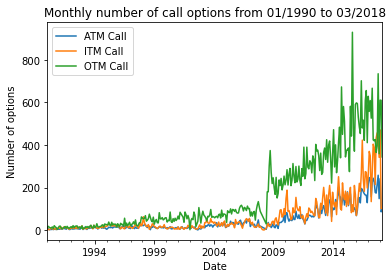

In [204]:
# Number of call by moneyness type throughout time:
ATM_call = SPX_Opt[(SPX_Opt["type"]==1) & (SPX_Opt["Moneyness group"]==0)]["Date"].value_counts()
ATM_call = ATM_call.sort_index()
ITM_call = SPX_Opt[(SPX_Opt["type"]==1) & (SPX_Opt["Moneyness group"]==1)]["Date"].value_counts() 
ITM_call= ITM_call.sort_index()
OTM_call = SPX_Opt[(SPX_Opt["type"]==1) & (SPX_Opt["Moneyness group"]==-1)]["Date"].value_counts()
OTM_call = OTM_call.sort_index()

plt.xlabel('Date')
plt.ylabel('Number of options')
plt.title("Monthly number of call options from 01/1990 to 03/2018")
ATM_call.plot(label="ATM Call")
ITM_call.plot(label="ITM Call")
OTM_call.plot(label="OTM Call")
plt.legend()

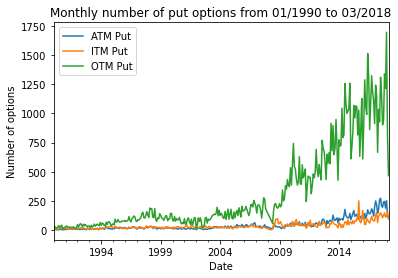

In [205]:
# Number of put by moneyness type throughout time:
ATM_put = SPX_Opt[(SPX_Opt["type"]==2) & (SPX_Opt["Moneyness group"]==0)]["Date"].value_counts()
ATM_put = ATM_put.sort_index()
ITM_put = SPX_Opt[(SPX_Opt["type"]==2) & (SPX_Opt["Moneyness group"]==1)]["Date"].value_counts()
ITM_put = ITM_put.sort_index()
OTM_put = SPX_Opt[(SPX_Opt["type"]==2) & (SPX_Opt["Moneyness group"]==-1)]["Date"].value_counts()
OTM_put = OTM_put.sort_index()

plt.xlabel('Date')
plt.ylabel('Number of options')
plt.title("Monthly number of put options from 01/1990 to 03/2018")
ATM_put.plot(label="ATM Put")
ITM_put.plot(label="ITM Put")
OTM_put.plot(label="OTM Put")
plt.legend()

#### Computed and plotted the average Implied Volatility by option type and moneyness

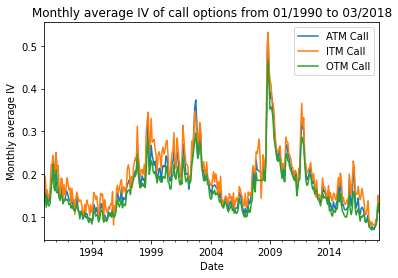

In [207]:
#Call & IV
ATM_call = SPX_Opt[(SPX_Opt["type"]==1) & (SPX_Opt["Moneyness group"]==0)]
ATM_call = ATM_call.groupby(['Date']).IVol.agg("mean")
ITM_call = SPX_Opt[(SPX_Opt["type"]==1) & (SPX_Opt["Moneyness group"]==1)]
ITM_call = ITM_call.groupby(['Date']).IVol.agg("mean")
OTM_call = SPX_Opt[(SPX_Opt["type"]==1) & (SPX_Opt["Moneyness group"]==-1)]
OTM_call = OTM_call.groupby(['Date']).IVol.agg("mean")

plt.xlabel('Date')
plt.ylabel('Monthly average IV')
plt.title("Monthly average IV of call options from 01/1990 to 03/2018")
ATM_call.plot(label="ATM Call")
ITM_call.plot(label="ITM Call")
OTM_call.plot(label="OTM Call")
plt.legend()

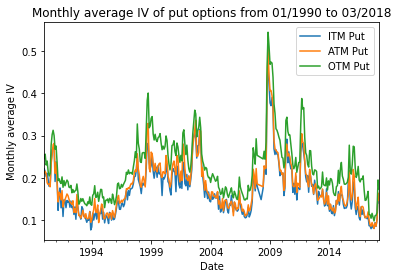

In [208]:
# Put & IV
ATM_put = SPX_Opt[(SPX_Opt["type"]==2) & (SPX_Opt["Moneyness group"]==0)]
ATM_put = ATM_put.groupby(['Date']).IVol.agg("mean")
ITM_put = SPX_Opt[(SPX_Opt["type"]==2) & (SPX_Opt["Moneyness group"]==1)]
ITM_put = ITM_put.groupby(['Date']).IVol.agg("mean")
OTM_put = SPX_Opt[(SPX_Opt["type"]==2) & (SPX_Opt["Moneyness group"]==-1)]
OTM_put = OTM_put.groupby(['Date']).IVol.agg("mean")

plt.xlabel('Date')
plt.ylabel('Monthly average IV')
plt.title("Monthly average IV of put options from 01/1990 to 03/2018")

ITM_put.plot(label="ITM Put")
ATM_put.plot(label="ATM Put")
OTM_put.plot(label="OTM Put")

plt.legend()

### Question 3 - Focusing on February 2018

In [110]:
df_feb18 = SPX_Opt[(SPX_Opt["month"]==2) & (SPX_Opt["year"]==2018)]
df_feb18

,IVol,day,maturity,month,price,stock,strike,type,year,Moneyness group,date,Date
215827,0.1682,7,9,2,93.40,2681.7,2600,1,2018,1,2018-02-07,2018-02
215828,0.1682,7,9,2,52.70,2681.7,2650,1,2018,1,2018-02-07,2018-02
215829,0.1682,7,9,2,26.00,2681.7,2690,1,2018,0,2018-02-07,2018-02
215830,0.1665,7,9,2,3.75,2681.7,2770,1,2018,-1,2018-02-07,2018-02
215831,0.1665,7,9,2,3.80,2681.7,2775,1,2018,-1,2018-02-07,2018-02
...,...,...,...,...,...,...,...,...,...,...,...,...
217701,0.1169,28,296,2,2.45,2713.8,3400,1,2018,-1,2018-02-28,2018-02
217702,0.1551,28,296,2,2.01,2713.8,1175,2,2018,-1,2018-02-28,2018-02
217703,0.1551,28,296,2,3.00,2713.8,1250,2,2018,-1,2018-02-28,2018-02
217704,0.1551,28,296,2,3.00,2713.8,1275,2,2018,-1,2018-02-28,2018-02


In [100]:
call_df = df_feb18[df_feb18["type"]==1]
put_df = df_feb18[df_feb18["type"]==2]

#### Computed the interest rate used to value each option

In [106]:
interest_rate = []

for i in df_feb18.index:
    if df_feb18.loc[i,"type"] == 1:
        interest_rate.append(BScallRate(df_feb18.loc[i,"price"],
                                        df_feb18.loc[i,"IVol"],
                                        df_feb18.loc[i,"strike"],
                                        float(df_feb18.loc[i,"maturity"]/365),
                                        df_feb18.loc[i,"stock"]))
    else:
        interest_rate.append(BSputRate(df_feb18.loc[i,"price"],
                                        df_feb18.loc[i,"IVol"],
                                        df_feb18.loc[i,"strike"],
                                        float(df_feb18.loc[i,"maturity"]/365),
                                        df_feb18.loc[i,"stock"]))
        
interest_rate = np.array(interest_rate).reshape(-1)
df_feb18["interest rate"] = pd.Series(interest_rate, index = df_feb18.index)
df_feb18

<ipython-input-106-7b1d341ebbe2>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_feb18["interest rate"] = pd.Series(interest_rate, index = df_feb18.index)


,IVol,day,maturity,month,price,stock,strike,type,year,Moneyness group,date,Date,interest rate
215827,0.1682,7,9,2,93.40,2681.7,2600,1,2018,1,2018-02-07,2018-02,0.132786
215828,0.1682,7,9,2,52.70,2681.7,2650,1,2018,1,2018-02-07,2018-02,0.132271
215829,0.1682,7,9,2,26.00,2681.7,2690,1,2018,0,2018-02-07,2018-02,0.054545
215830,0.1665,7,9,2,3.75,2681.7,2770,1,2018,-1,2018-02-07,2018-02,0.008659
215831,0.1665,7,9,2,3.80,2681.7,2775,1,2018,-1,2018-02-07,2018-02,0.088620
...,...,...,...,...,...,...,...,...,...,...,...,...,...
217701,0.1169,28,296,2,2.45,2713.8,3400,1,2018,-1,2018-02-28,2018-02,-0.910000
217702,0.1551,28,296,2,2.01,2713.8,1175,2,2018,-1,2018-02-28,2018-02,0.100000
217703,0.1551,28,296,2,3.00,2713.8,1250,2,2018,-1,2018-02-28,2018-02,0.099817
217704,0.1551,28,296,2,3.00,2713.8,1275,2,2018,-1,2018-02-28,2018-02,0.100000


Text(0.5, 1.0, 'February 2018 daily average interest rate')

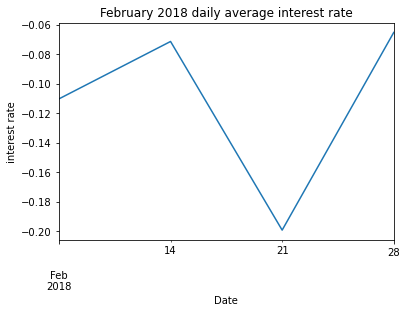

In [109]:
# compute the average interest rate for each day
df_feb18.groupby('date')['interest rate'].mean().plot()
plt.xlabel("Date")
plt.ylabel("interest rate")
plt.title("February 2018 daily average interest rate")

#### Scatter Plots of IV against moneyness by option type

In [186]:
# Call: IV vs Moneyness
call_df["Moneyness"] = call_df["stock"] / call_df["strike"]

<ipython-input-186-c25ba669b6bf>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  call_df["Moneyness"] = call_df["stock"] / call_df["strike"]


Text(0.5, 1.0, 'IV vs Moneyness for Call options')

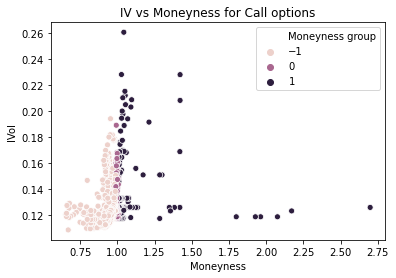

In [187]:
sns.scatterplot(data=call_df, x="Moneyness", y="IVol", hue ="Moneyness group")
plt.title("IV vs Moneyness for Call options")

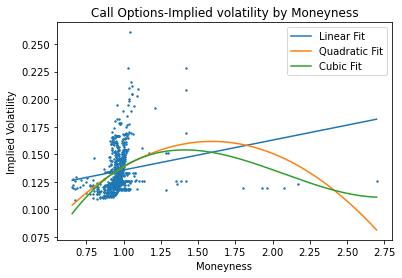

In [159]:
# Call - add linear, quadratic and cubit fits to the scatter plot
x_call = call_df["Moneyness"]
y_call = call_df["IVol"]

f0 = np.linspace(min(x_call),max(x_call),len(x_call))
f1 = np.poly1d(np.polyfit(x_call,y_call,1))
f2 = np.poly1d(np.polyfit(x_call,y_call,2))
f3 = np.poly1d(np.polyfit(x_call,y_call,3))

plt.scatter(x_call,y_call,s=2)
plt.plot(f0,f1(f0),label="Linear Fit")
plt.plot(f0,f2(f0),label="Quadratic Fit")
plt.plot(f0,f3(f0),label="Cubic Fit")
plt.legend()
plt.title("Call Options-Implied volatility by Moneyness") 
plt.xlabel("Moneyness")
plt.ylabel("Implied Volatility")
plt.show()

In [196]:
# Put: IV vs Moneyness
put_df["Moneyness"] = put_df["stock"] / put_df["strike"]

<ipython-input-196-e676615e5aec>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  put_df["Moneyness"] = put_df["stock"] / put_df["strike"]


Text(0.5, 1.0, 'IV vs Moneyness for Put options')

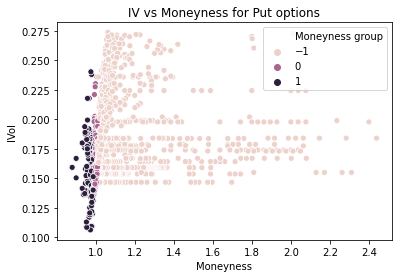

In [197]:
sns.scatterplot(data=put_df, x="Moneyness", y="IVol",hue="Moneyness group")
plt.title("IV vs Moneyness for Put options")

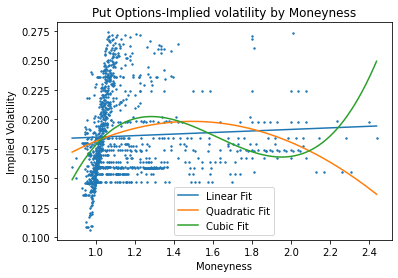

In [149]:
# Put - add linear, quadratic and cubit fits to the scatter plot
x_put = put_df["Moneyness"]
y_put = put_df["IVol"]

f00 = np.linspace(min(x_put),max(x_put),len(x_put))
f01 = np.poly1d(np.polyfit(x_put,y_put,1))
f02 = np.poly1d(np.polyfit(x_put,y_put,2))
f03 = np.poly1d(np.polyfit(x_put,y_put,3))

plt.scatter(x_put,y_put,s=2)
plt.plot(f00,f01(f00),label="Linear Fit")
plt.plot(f00,f02(f00),label="Quadratic Fit")
plt.plot(f00,f03(f00),label="Cubic Fit")
plt.legend()
plt.title("Put Options-Implied volatility by Moneyness") 
plt.xlabel("Moneyness")
plt.ylabel("Implied Volatility")
plt.show()

#### Estimated Dumas Deterministic Volatility Function (DVF)

In [165]:
#Adding the independent parameters as columns
df_feb18["K/S-1"] = df_feb18["strike"]/df_feb18["stock"]-1
df_feb18["abs(K/S-1)"] = abs(df_feb18["strike"]/df_feb18["stock"]-1)
df_feb18["(K/S-1)^2"] = (df_feb18["strike"]/df_feb18["stock"]-1)**2
df_feb18["(K/S-1)*abs(K/S-1)"] = df_feb18["K/S-1"]*df_feb18["abs(K/S-1)"]

<ipython-input-165-20ba7685cb3a>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_feb18["K/S-1"] = df_feb18["strike"]/df_feb18["stock"]-1
<ipython-input-165-20ba7685cb3a>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_feb18["abs(K/S-1)"] = abs(df_feb18["strike"]/df_feb18["stock"]-1)
<ipython-input-165-20ba7685cb3a>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentatio

In [166]:
#Splitting the dataset by option type
Call = df_feb18[df_feb18["type"]==1]
Put = df_feb18[df_feb18["type"]==2]

**Call - 2 methods (OLS / RMSE)**

In [167]:
# Call - OLS
X_C = Call[["K/S-1","abs(K/S-1)","(K/S-1)^2","(K/S-1)*abs(K/S-1)"]]
X_C = sm.add_constant(X_C)
y_C = Call["IVol"]
OLS_Call = sm.OLS(y_C, X_C).fit()
OLS_Call.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   IVol   R-squared:                       0.175
Model:                            OLS   Adj. R-squared:                  0.171
Method:                 Least Squares   F-statistic:                     42.14
Date:                Wed, 02 Mar 2022   Prob (F-statistic):           4.63e-32
Time:                        00:19:46   Log-Likelihood:                 2082.4
No. Observations:                 797   AIC:                            -4155.
Df Residuals:                     792   BIC:                            -4131.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  0.1417      0.001    130.029      0.000       0.140       0.144
K/S-1                 -0.1742      0.017    -10.226      0.000      -0.208      -0.141
abs(K/S-1)            -0.0025      0.022     -0.112      0.911      -0.046       0.041
(K/S-1)^2             -0.0531      0.048     -1.107      0.269      -0.147       0.041
(K/S-1)*abs(K/S-1)     0.3387      0.040      8.433      0.000       0.260       0.418
==============================================================================
Omnibus:                      225.670   Durbin-Watson:                   0.393
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              641.348
Skew:                           1.410   Prob(JB):                    5.41e-140
Kurtosis:                       6.370   Cond. No.                         91.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [168]:
# Splitting the data into test/train
X_C_train, X_C_test, y_C_train, y_C_test = train_test_split(X_C,y_C)

In [169]:
#Implement a Linear Regression
LR_Call = LinearRegression()
LR_Call.fit(X_C_train,y_C_train)

LinearRegression()

In [170]:
#Making Predictions
y_C_pred = LR_Call.predict(X_C_test)

In [171]:
#Model Evaluation with RMSE
print(f"RMSE for Call: {np.sqrt(metrics.mean_squared_error(y_C_test,y_C_pred))}")

RMSE for Call: 0.016091361948536973


**Put - 2 methods (OLS / RMSE)**

In [172]:
# Put - OLS
X_P = Put[["K/S-1","abs(K/S-1)","(K/S-1)^2","(K/S-1)*abs(K/S-1)"]]
X_P = sm.add_constant(X_P)
y_P = Put["IVol"]
OLS_Put = sm.OLS(y_P, X_P).fit()
OLS_Put.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   IVol   R-squared:                       0.137
Model:                            OLS   Adj. R-squared:                  0.134
Method:                 Least Squares   F-statistic:                     42.71
Date:                Wed, 02 Mar 2022   Prob (F-statistic):           2.75e-33
Time:                        00:21:04   Log-Likelihood:                 2162.1
No. Observations:                1082   AIC:                            -4314.
Df Residuals:                    1077   BIC:                            -4289.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  0.1864      0.002     99.639      0.000       0.183       0.190
K/S-1                 -0.7186      0.077     -9.376      0.000      -0.869      -0.568
abs(K/S-1)            -0.6075      0.086     -7.048      0.000      -0.777      -0.438
(K/S-1)^2              5.4309      1.066      5.095      0.000       3.340       7.522
(K/S-1)*abs(K/S-1)     5.7016      1.056      5.400      0.000       3.630       7.773
==============================================================================
Omnibus:                       91.124   Durbin-Watson:                   0.513
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               78.318
Skew:                           0.581   Prob(JB):                     9.85e-18
Kurtosis:                       2.378   Cond. No.                     1.52e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.52e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [173]:
# Splitting the data into test/train
X_P_train, X_P_test, y_P_train, y_P_test = train_test_split(X_P,y_P)

In [174]:
#Implement a Linear Regression
LR_Put = LinearRegression()
LR_Put.fit(X_P_train,y_P_train)

LinearRegression()

In [175]:
#Making Predictions
y_P_pred = LR_Put.predict(X_P_test)

In [176]:
#Model Evaluation with RMSE
print(f"RMSE for Call: {np.sqrt(metrics.mean_squared_error(y_P_test,y_P_pred))}")

RMSE for Call: 0.03339074823461978
